In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random as rn
import shapely
import json
from shapely import geometry
import time

# 3D Plot
from mpl_toolkits import mplot3d

# Custom Classes
from SE2_Legacy import SE2, se2
from Camera import Camera
from Dynamic import DynamicMap

In [10]:
# Global functions
def SE2_log(M):
    """
    Matrix logarithm for SE2 Lie group
    """
    theta = np.arctan2(M[1, 0], M[0, 0])
    if np.abs(theta) < 1e-6:
        A = 1 - theta**2/6 + theta**4/120
        B = theta/2 - theta**3/24 + theta**5/720
    else:
        A = np.sin(theta)/theta
        B = (1 - np.cos(theta))/theta
    V_inv = np.array([[A, B], [-B, A]])/(A**2 + B**2)
    t = M[:2, 2]
    u = V_inv.dot(t)
    return np.array([u[0], u[1], theta])

def SE2_exp(v):
    """
    SE2 matrix exponential
    """
    x, y, theta = v
    if np.abs(theta) < 1e-6:
        A = 1 - theta**2/6 + theta**4/120
        B = theta/2 - theta**3/24 + theta**5/720
    else:
        A = np.sin(theta)/theta
        B = (1 - np.cos(theta))/theta
    V = np.array([[A, -B], [B, A]])
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]])
    u = np.array([[x, y]]).T
    return np.block([
        [R, V.dot(u)],
        [0, 0,  1]])

def SE2_to_param(M):
    """
    From matrix to [theta, x, y]
    """
    theta = np.arctan2(M[1, 0], M[0, 0])
    x = M[0, 2]
    y = M[1, 2]
    return np.array([x, y, theta])

In [11]:
# R2T2
class R2T2:
    """
    RRT with Time Domain

    TODO
    1. Complete 2D RRT
    1.1 Build RRT with SE2
    2. Complete 3D RRTs
    """
    
    def __init__(self, x0, x1, t, vehicle, map_in):
        # x: 2x1 vector, [xinit, xfin]
        xi_x = x0[0]
        xi_y = x0[1]
        self.thet_init = x0[2]
        self.xinit = (xi_x, xi_y, self.thet_init)
        xf_x = x1[0]
        xf_y = x1[1]
        self.thet_fin = x1[2]
        self.xfin = (xf_x, xf_y, self.thet_fin)
        
        # t: 3x1 vector, [trange, delt, endtime]
        self.trange = t[0]
        self.delt = t[1]
        self.endtime = t[2]
        
        # vehcile: dictionary
        # key: v
        # 'v' = max velocity
        # 'radius' = radius
        self.vmax = vehicle['v']
        self.vrad = vehicle['radius']

        # map: dictionary
        # key: n, st, dy, curr
        # 'n' = repeat period length
        # 'ncam' = number of camera present
        # 'st' = static map
        # ['st']['size'] = 4x1 vector [x0, xmax, y0, ymax]
        # ['st']['n'] = number of buildings
        # ['st'][str(i)], i = number // building poly  at ith index
        # 'dy' = repeating dynamic map with n periods
        # ['dy'][str(i)], i = number // dynamic map at ith index
        # 'curr' = static + dynamic = current map
        # ['curr'][str(i)], i = number = currnet map at ith index
        self.map_st = map_in['st']
        self.map_dy = map_in['dy']
        #self.map_period = map_in['n']
        #self.map_curr = map_in['curr']

    # Functios for Step 3
    def gen_node(self, r, qnear, c, t_in):
        count = c

        # Generate qrand
        # This is polar method
        qrand_r = rn.uniform(0, r)
        qrand_th = rn.uniform(0, 2*np.pi)
        qrand_x = qrand_r*np.cos(qrand_th)
        qrand_y = qrand_r*np.sin(qrand_th)
        qrand = np.array([qrand_x+qnear[0], qrand_y+qnear[1], qrand_th])
        Qrand_SE2 = SE2(qrand[0], qrand[1], qrand[2])

        if c <= 100:
            if self.static_bound(qrand) and not Qrand_SE2 is None and not self.dynamic_bound(qrand, t_in):
                return Qrand_SE2
            else:
                count+=1
                return self.gen_node(r,qnear, count, t_in)
        else:
            # If loop is too much, just return stationary
            return SE2(qnear[0], qnear[1], qnear[2])
        
    def building_bound(self, xi):
        # Check if point is inside building polygon
        smap = self.map_st
        check_vec = []
        for i in range(smap['n']):
            # ibuilding is a list of vertex of building polygon
            ibuilding = smap[str(i)]
            wall = geometry.LineString(ibuilding)
            building = geometry.Polygon(wall)

            check_vec.append(building.contains(geometry.Point(xi[0],xi[1])))

        # Add all boolean values,
        # if 1: Point inside building
        # if 0: Point not contained within building
        return np.sum(check_vec)

    def move_bound(self, r, xi):
        # Is xi within possible movement range in given time?
        return bool(xi[0]**2+xi[1]**2 <= r)

    def in_map(self, xi):
        # Check if ponit is within map
        return (xi[0] >= self.map_st['size'][0] and xi[0]<=self.map_st['size'][1] and xi[1] >= self.map_st['size'][2] and xi[1]<=self.map_st['size'][3])

    def static_bound(self, xi):
        return self.in_map(xi) and not self.building_bound(xi)
    
    def dynamic_bound(self, xi, t_in):
        """
        1. At given time input t_in, obtain dynamic masking.
        2. Then, check whether or not that given piont is inside any camera FOV
        Input: t_in = time index (continuous)
        Output: Dynamic masking at that point
        """
        # Continuous Dynamic Map function is generated during setup phase
        dmap = self.map_dy

        # Extract camera function dictionary
        # Camera function has following keys
        # ['n'] = number of camera
        # [str(i)]['Camera'] = ith camera object
        # [str(i)]['FOV'] = Computed camera FOV triangle vertices
        # [str(i)]['FOV_Poly'] = Computed polygon object from FOV vertices
        cameras = dmap.gen_cam(t_in)
        ncam = cameras['n']
        check_vec = []
        for i in range(ncam):
            # Extract FOV Polynomial of ith camera
            cam_i = cameras[str(i)]['FOV_Poly']
            check_vec.append(cam_i.contains(geometry.Point(xi[0],xi[1])))
        
        # Add all boolean values,
        # if 1: Point inside any camera FOVs
        # if 0: Point is outside of all camera FOVs
        return np.sum(check_vec)

    # Functions for Step 4
    def nearest(self, G, xi):
        3# Find nearest vertex
        range_vec = []
        for ii in range(len(G['vertex'])):
            VERT_avail = G['vertex'][ii]
            vert_avail = VERT_avail.SE2param()
            temp = G['t'][ii]
            range_vec.append(np.sqrt((xi[0] - vert_avail[0])**2 + (xi[1] - vert_avail[1])**2))

        Xnear = G['vertex'][range_vec.index(min(range_vec))]
        t_at_Xnear = G['t'][range_vec.index(min(range_vec))]

        return Xnear, t_at_Xnear
    
    # Functions for Step 5
    def find_u_R_d(self, X0, X1):
        # Compute arc length, radius, distance
        M = X0.inv()@X1.matrix()
        dx, dy, dth = SE2_to_param(M)

        d = np.sqrt(dx**2 + dy**2)
        alpha = np.arctan2(dy, dx)

        if np.abs(alpha) > 1e-3:
            R = d/(2*np.sin(alpha))
            u = 2*R*alpha
        else:
            R = np.infty
            u = d

        return u, R, d

    def local_path_planner(self, X0, X1, dist):
        # Plot route from start X0 to end X1
        u, R, d = self.find_u_R_d(X0, X1)
        if np.abs(u) > dist:
            u = dist#*np.sign(u)

        # Compute turn angle omega
        if np.isclose(np.abs(R),0):
            omega = 0
        else:
            omega = u/R

        v = se2(u, 0, omega)
        V = v.exp()

        return X0.matrix()@V
    
    def distance_R2T2(self, ti, X0, X1):
        u, R, d = self.find_u_R_d(X0, X1)
        cost = self.vmax*ti
        if d > 0.1 and np.abs(R) < 0.5:
            cost = np.infty
        
        if u < 0:
            cost = np.infty
        return cost
    
    def current_pos(self, Q0, Q1, V, qt_vec):
        """
        TODO
        If current_pos is outside of bounds
        -> return to position where it is valid
        """
        v = SE2_log(Q0.inv()@V)
        curr_path = {}
        curr_path['x'] = []
        curr_path['y'] = []
        curr_path['t'] = []
        curr_path['theta'] = []
        tscale = qt_vec[-1]-qt_vec[0]

        #for tt in np.arange(0,1,self.delt):
        # for tt in np.linspace(0, 1, len(qt_vec)):
        for tt in np.linspace(0, 1, 100):
        #for tt in np.linspace(0,qt_vec[-1]-qt_vec[0],len(qt_vec)):
            Q = Q0.matrix()@(SE2_exp(v*tt))
            xt, yt, thetat = SE2_to_param(Q)
            curr_path['x'].append(xt)
            curr_path['y'].append(yt)
            curr_path['t'].append(qt_vec[0]+tscale*tt)
            curr_path['theta'].append(thetat)

            # Check if current position is on collision point
            if self.collision_check(self.vrad, Q0, Q, [tt], 1):
                return SE2(x=xt, y=yt, theta=thetat), curr_path
            
        return SE2(x=xt, y=yt, theta=thetat), curr_path
    
    def collision_check(self, vehicle_radius, Q0, Q1, qtvec, steps):
        """
        TODO
        Add collision for dynamic case
        """
        V = Q0.inv()@(Q1)
        v = SE2_log(V)
        test_vector = np.linspace(0,1,steps)
        for tt in test_vector:
            Q = Q0.matrix()@(SE2_exp(v*tt))
            xt, yt, thetat = SE2_to_param(Q)
            
            # check map bounds
            if not self.in_map([xt, yt, thetat]):
                return True

            # check collision with static obstacles
            if self.in_map([xt, yt, thetat]):                
                if bool(self.building_bound([xt, yt, thetat])):
                    return True
            # check collision with dynamic obstacles at matching time in time vector qtvec
            t_in_to_test, = np.where(test_vector == tt)
            t_to_test = qtvec[t_in_to_test[0]]
            if bool(self.dynamic_bound((xt, yt), t_to_test)):
                return True
        return False
    
    # Functions for Step 6
    def get_range(self, Q, Xf):
        diff = Xf.matrix() - Q.matrix()
        return np.sqrt((diff[0,2])**2 + (diff[1,2])**2)
    
    # Functions for Step 7
    def rrt_course(self, G):
        # print('Plotting Course')
        neighbor = G['neighbor']
        key_list = neighbor.keys()

        # Route Index
        route = []

        def match_vertex(v0, v1):
            tol = 1e-2
            if np.abs(v0[0]-v1[0])<tol and np.abs(v0[1]-v1[1])<tol:
                return True
            else:
                return False

        # Start from initial point
        # points in se3
        q0 = self.xinit
        qf = self.xfin
        qcheck = qf

        # Find matching vertices
        castellan = True
        while castellan:
            # print('Blessing the Machine...')
            for ii in range(len(key_list)):
                # Extract iith key
                currkey = list(key_list)[ii]
                if match_vertex(qcheck, neighbor[str(currkey)][1]):
                    # route.append(ii)
                    route.append(currkey)
                    qcheck = neighbor[str(currkey)][0]
                    # Return route to final point
                    if match_vertex(qcheck, q0):
                        castellan = False
                        return route
                    
    def R2T2_2D(self, compTimeLimit, switch):
        """
        This a 2D RRT with time domain as z axis
        1. Generate Random t
        2. Find range of r it can reach
        3. Generate random coordinate x1, and check whether or not it is located inside the cone, and find closest qnear // Or can we select any number within cone volume?
           80% to move to new qrand
           10% to stay
           10% to move to final point
        4. IF x1 is located inside code, connect it with start point x0 // IF x1 NOT located in cone, regen random coordinate
        5. Can there be path generated?
        6. Repeat 3-4 until cone include final point
        7. Connect from xfin to xinit and generate path
        """
        # Initial Variables
        xi = self.xinit
        xf = self.xfin
        dt = self.delt
        trange = self.trange

        # Set Emptry Storages
        # Vertex:
        # Edge: 
        # t: 
        G = {}
        G['vertex'] = []
        G['vertex_with_time'] = {}
        G['neighbor'] = {}
        G['edge'] = {}
        G['edge_node'] = []
        G['route'] = []
        G['route_with_time'] = []
        G['t'] = []
        
        # Initialize R2T2
        Xi = SE2(x=xi[0], y=xi[1], theta=xi[2])
        Xf = SE2(x=xf[0], y=xf[1], theta=xf[2])
        Qnear = SE2(x=xi[0], y=xi[1], theta=xi[2])
        G['vertex'].append(Qnear)
        G['vertex_with_time'][str(0)] = [Qnear.SE2param(), 0]
        G['t'].append(0)
        Qnear_prev = G['vertex'][-1]
        tprev = 0
        counter_prev = 0
        map_size = self.map_st['size']
        dmap = self.map_dy
        bad_path = []

        # Start loop, and repeat until route toward final point
        repeat_R2T2 = True
        debug = False
        counter = 0

        # End condition
        dist_best = self.get_range(Xi, Xf)
        dist_tol = 1e-1

        execution_time_vec = {}
        execution_time_vec['Sampling'] = []
        execution_time_vec['NearestNode'] = []
        execution_time_vec['RouteCheck'] = []
        execution_time_vec['CollisoinCheck'] = []
        execution_time_vec['CurrPos'] = []

        start = time.time()
        while repeat_R2T2:
            # Step 1
            # Generate random time t to move
            ti = rn.uniform(0,trange)

            # Step 2
            # Compute possible movement range
            mv_R = self.vmax*ti

            # Step 3
            # Choose next move qnext
            # 80% -> move to random point qrand
            # 10% -> remain stationary
            # 10% -> route to final point
            if not debug:
                # switch = [.8, .1, .1]
                Qnear = None
                Qnear_exist = False
                # print(bool(Qnear_exist))
                sample_start = time.time()
                while not Qnear_exist:
                    if Qnear is None:
                        choose = rn.uniform(0,1)
                        if choose >= 0 and choose <= switch[0]:
                            # Get random point x1, and check whether or not it is valid
                            Qnext = self.gen_node(mv_R, Qnear_prev.SE2param(), 0, tprev)
                            Qnear_exist = True
                        elif choose > switch[0] and choose <= (switch[0]+switch[1]) and switch[1] > 0:                       
                            Qnext = Qnear_prev
                            Qnear_exist = True
                        else:
                            Qnext = SE2(xf[0], xf[1], xf[2])
                            Qnear_exist = True
                execution_time_vec['Sampling'].append(time.time()-sample_start)
                
                # Step 4
                # Find cloest point from qnear
                nearest_start = time.time()
                Qnear, tnear = self.nearest(G, Qnext.SE2param())
                tnext = tnear+ti
                execution_time_vec['NearestNode'].append(time.time()-nearest_start)
                
            # print('Qnear ', Qnear.SE2param())
            # print('Qnext ', Qnext.SE2param())
            # print('trange ', trange)
            # print('ti ', ti)
            # print('tnear ', tnear)
            # print('tnext ', tnext)
            st_tvec = np.arange(tnear, tnext, self.delt)

            # Step 5
            # Generate Path and check collision
            # This is done in SE2 Lie Group for 2D R2T2
            # cost_R2T2 = self.distance_R2T2(ti, Qnear, Qnext)
            route_start = time.time()
            Qroute = self.local_path_planner(Qnear, Qnext, self.vmax*ti)
            execution_time_vec['RouteCheck'].append(time.time()-route_start)
            #Qroute = self.local_path_planner(Qnear, Qnext, cost_R2T2)

            # Check Collision
            # If collision occur, we ignore that path
            # If collision doesn't occur, carry on
            # if self.collision_check(self.vrad, Qnear, Qroute, st_tvec, len(st_tvec)):
            collision_check_start = time.time()
            collision_checked = self.collision_check(self.vrad, Qnear, Qroute, st_tvec, len(st_tvec))
            execution_time_vec['CollisoinCheck'].append(time.time()-collision_check_start)
            if collision_checked:
                bad_path.append(Qnext)
                # print('Route Collision Detected')
            #    print('Route: ', SE2_to_param(Qroute))
            else:
                # Compute current position as time may differ
                curr_pos_start = time.time()
                Qcurr, path_curr = self.current_pos(Qnear, Qnext, Qroute, st_tvec)
                execution_time_vec['CurrPos'].append(time.time()-curr_pos_start)

            # Step 6
            # Check if destination is reached
            # Update Dictionary
                a = Qnear.SE2param()
                b = Qcurr.SE2param()
                edge = [a[0], b[0]], [a[1], b[1]], [tnear, tnear+ti]
                G['vertex'].append(Qcurr)
                G['vertex_with_time'][str(counter)] = [Qcurr.SE2param(), tnear+ti]
                G['edge'][str(counter)] = path_curr
                # G['edge_node'].append([str(counter_prev), str(counter)])
                G['neighbor'][str(counter)] = [(a[0], a[1], tnear), (b[0], b[1], tnear + ti)]
                G['t'].append(tnear + ti)
                counter += 1

            # Update termination condition
                dist_curr = self.get_range(Qcurr, Xf)
                if dist_curr < dist_best:
                    dist_best = dist_curr
                    Qnear_prev = Qcurr
                    tprev = tnear+ti

            # If within tolerance, we stop and return path
                if dist_best < dist_tol:
                    print('Destination Reached')
                    # Stop iteration
                    repeat_R2T2 = False

                    # Find route to Final Point
                    route = self.rrt_course(G)
                    G['route'] = route
                    # route_tvec = []
                    # for ri in np.flip(route):
                    #     route_tvec.append(G['t'][ri])
                    # route_tvec.append(tnext)
                    
                    # with open('R2T2.txt', 'w') as R2T2_output:
                    #     R2T2_output.write(json.dumps(G))
                    return 1, time.time() - start, execution_time_vec, G
            # If not, we update for next loop
            counter += 1

            # Break out if loop is too long
            if np.abs(G['t'][-1]-self.endtime) <= 1e-1 or (time.time()-start) >= compTimeLimit:
                # print('Fail to reach destination in time')
                return 0, time.time()-start, execution_time_vec, G
            
    def RRT_Connect(self, compTimeLimit, switch):
        """
        This a 2D RRT with time domain as z axis
        1. Generate Random t
        2. Find range of r it can reach
        3. Generate random coordinate x1, and check whether or not it is located inside the cone, and find closest qnear // Or can we select any number within cone volume?
           80% to move to new qrand
           10% to stay
           10% to move to final point
        4. IF x1 is located inside code, connect it with start point x0 // IF x1 NOT located in cone, regen random coordinate
        5. Can there be path generated?
        6. Repeat 3-4 until cone include final point
        7. Connect from xfin to xinit and generate path
        """
        # Initial Variables
        xi = self.xinit
        xf = self.xfin
        dt = self.delt
        trange = self.trange
        final_path_length = 0
        final_path_time = 0

        # Set Emptry Storages
        # Vertex:
        # Edge: 
        # t: 
        G = {}
        G['vertex'] = []
        G['neighbor'] = {}
        G['edge'] = {}
        G['route'] = []
        G['route_'] = []
        G['t'] = []
        
        # Initialize R2T2
        Xi = SE2(x=xi[0], y=xi[1], theta=xi[2])
        Xf = SE2(x=xf[0], y=xf[1], theta=xf[2])
        Qnear = SE2(x=xi[0], y=xi[1], theta=xi[2])
        G['vertex'].append(Qnear)
        G['t'].append(0)
        Qnear_prev = G['vertex'][-1]
        tprev = 0
        map_size = self.map_st['size']
        dmap = self.map_dy
        bad_path = []

        # Start loop, and repeat until route toward final point
        repeat_R2T2 = True
        debug = False
        counter = 0

        # End condition
        dist_best = self.get_range(Xi, Xf)
        dist_tol = 1e-1

        execution_time_vec = {}
        execution_time_vec['Sampling'] = []
        execution_time_vec['NearestNode'] = []
        execution_time_vec['RouteCheck'] = []
        execution_time_vec['CollisoinCheck'] = []
        execution_time_vec['CurrPos'] = []

        start = time.time()
        while repeat_R2T2:
            # Step 1
            # Generate random time t to move
            ti = rn.uniform(0,trange)

            # Step 2
            # Compute possible movement range
            mv_R = self.vmax*ti

            # Step 3
            # Choose next move qnext
            # 80% -> move to random point qrand
            # 10% -> remain stationary
            # 10% -> route to final point
            if not debug:
                # switch = [.8, .1, .1]
                Qnear = None
                Qnear_exist = False
                # print(bool(Qnear_exist))
                sample_start = time.time()
                while not Qnear_exist:
                    if Qnear is None:
                        choose = rn.uniform(0,1)
                        if choose >= 0 and choose <= switch[0]:
                            # Get random point x1, and check whether or not it is valid
                            Qnext = self.gen_node(mv_R, Qnear_prev.SE2param(), 0, tprev)
                            Qnear_exist = True
                        elif choose > switch[0] and choose <= (switch[0]+switch[1]) and switch[1] > 0:                       
                            Qnext = Qnear_prev
                            Qnear_exist = True
                        else:
                            Qnext = SE2(xf[0], xf[1], xf[2])
                            Qnear_exist = True
                execution_time_vec['Sampling'].append(time.time()-sample_start)
                
                # Step 4
                # Find cloest point from qnear
                nearest_start = time.time()
                Qnear, tnear = self.nearest(G, Qnext.SE2param())
                tnext = tnear+ti
                execution_time_vec['NearestNode'].append(time.time()-nearest_start)
                
            # print('Qnear ', Qnear.SE2param())
            # print('Qnext ', Qnext.SE2param())
            # print('trange ', trange)
            # print('ti ', ti)
            # print('tnear ', tnear)
            # print('tnext ', tnext)
            st_tvec = np.arange(tnear, tnext, self.delt)

            # Step 5
            # Generate Path and check collision
            # This is done in SE2 Lie Group for 2D R2T2
            # cost_R2T2 = self.distance_R2T2(ti, Qnear, Qnext)
            route_start = time.time()
            Qroute = self.local_path_planner(Qnear, Qnext, self.vmax*ti)
            execution_time_vec['RouteCheck'].append(time.time()-route_start)
            #Qroute = self.local_path_planner(Qnear, Qnext, cost_R2T2)

            # Check Collision
            # If collision occur, we ignore that path
            # If collision doesn't occur, carry on
            # if self.collision_check(self.vrad, Qnear, Qroute, st_tvec, len(st_tvec)):
            collision_check_start = time.time()
            collision_checked = self.collision_check(self.vrad, Qnear, Qroute, st_tvec, len(st_tvec))
            execution_time_vec['CollisoinCheck'].append(time.time()-collision_check_start)
            if collision_checked:
                bad_path.append(Qnext)
                # print('Route Collision Detected')
            #    print('Route: ', SE2_to_param(Qroute))
            else:
                # Compute current position as time may differ
                curr_pos_start = time.time()
                Qcurr, path_curr = self.current_pos(Qnear, Qnext, Qroute, st_tvec)
                execution_time_vec['CurrPos'].append(time.time()-curr_pos_start)

            # Step 6
            # Check if destination is reached
            # Update Dictionary
                a = Qnear.SE2param()
                b = Qcurr.SE2param()
                edge = [a[0], b[0]], [a[1], b[1]], [tnear, tnear+ti]
                G['vertex'].append(Qcurr)
                G['edge'][str(counter)] = path_curr
                # G['edge'][str(len(G['vertex']))] = path_curr
                G['neighbor'][str(counter)] = [(a[0], a[1], tnear), (b[0], b[1], tnear + ti)]
                G['t'].append(tnear + ti)

            # Update termination condition
                dist_curr = self.get_range(Qcurr, Xf)
                counter += 1
                if dist_curr < dist_best:
                    dist_best = dist_curr
                    Qnear_prev = Qcurr
                    tprev = tnear+ti
                    final_path_length += dist_best
                    final_path_time += ti

            # If within tolerance, we stop and return path
                if dist_best < dist_tol:
                    print('Destination Reached')
                    # Stop iteration
                    repeat_R2T2 = False

                    # Find route to Final Point
                    route = self.rrt_course(G)
                    G['route'] = route
                    route_tvec = []
                    for ri in np.flip(route):
                        route_tvec.append(G['t'][ri])
                    route_tvec.append(tnext)
                    
                    # with open('R2T2.txt', 'w') as R2T2_output:
                    #     R2T2_output.write(json.dumps(G))
                    return 1, time.time() - start, execution_time_vec, final_path_length, final_path_time, G
            # If not, we update for next loop
            # counter += 1

            # Break out if loop is too long
            if np.abs(G['t'][-1]-self.endtime) <= 1e-1 or (time.time()-start) >= compTimeLimit:
                # print('Fail to reach destination in time')
                return 0, time.time()-start, execution_time_vec, final_path_length, final_path_time, G

In [12]:
# Test case
# Initial, Final Positions
x0 = np.array([0, 0, 0])
x1 = np.array([8, 0, 0])
t = [200, .25, 500]

# Vehicle Spec
vehicle = {}
vehicle['v'] = 1.5
vehicle['radius'] = 0.5

# Map
map_in = {}
# Static Map
map_in['st'] = {}
map_in['st']['size'] = np.array([-5, 15, -15, 15])
# Single buliding example
map_in['st']['n'] = 1
map_in['st']['0'] = np.array([
    (2.5,5), (7.5,10), (7.5,-10), (2.5,-5)
])

# Dynamic Map
# This is a continuous function generates camera FOV coverages
# Input is map_in, and time input t_in
map_in['n'] = t[0]
map_in['ncam'] = 1

# Single camera example, surveying final location xfin
# Camera Position
cam_x = np.array([7.5])
cam_y = np.array([rn.uniform(-5, 5)])
cam_dict = {}
cam_dict['n'] = len(cam_x)
cam_dict['x'] = cam_x
cam_dict['y'] = cam_y

# Camera Spec
tilt_limit = np.array([np.pi, 0]) #[upper, lower]
fov_ang = np.deg2rad(20)
fov_rng = 7.5 #[m]
cam_period = t[0]
cam_increment = t[1]
cam_dict['spec'] = {}
cam_dict['spec']['bound'] = tilt_limit
cam_dict['spec']['fov'] = [fov_ang, fov_rng]
cam_dict['spec']['cam_time'] = [cam_period, cam_increment]

# Test dynamic map
dmap = DynamicMap(map_in, cam_dict)
map_in['dy'] = dmap

test = R2T2(x0, x1, t, vehicle, map_in)

In [13]:
mc_iter = 1
K = 7
# compTimeVec = [0.001, 0.01, 0.1, 1, 3, 5, 7, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50]
compTimeVec = [10]
# compTimeVec = [0.1, 1, 5, 10, 20, 30]
print(compTimeVec)
print(2*np.sum(compTimeVec)*mc_iter/3600)

[10]
0.005555555555555556


In [14]:
wait_switch = [.8, .1, .1]
RRTC_switch = [0.95, 0, 0.05]
success_vec_waitGo = []
success_vec_RRTC = []
avg_compTime_vec_waitGo = []
avg_compTime_vec_RRTC = []

for ti in compTimeVec:
    # Single camera example, surveying final location xfin
    # Camera Position
    cam_x = np.array([7.5])
    # cam_y = np.array([rn.uniform(-10, 10)])
    cam_y = np.array([rn.uniform(-5, 5)])
    cam_dict = {}
    cam_dict['n'] = len(cam_x)
    cam_dict['x'] = cam_x
    cam_dict['y'] = cam_y

    # Camera Spec
    tilt_limit = np.array([np.pi, 0]) #[upper, lower]
    fov_ang = 20#np.deg2rad(rn.uniform(10, 30))
    fov_rng = 7.5 #[m]
    cam_period = t[0]
    cam_increment = t[1]
    cam_dict['spec'] = {}
    cam_dict['spec']['bound'] = tilt_limit
    cam_dict['spec']['fov'] = [fov_ang, fov_rng]
    cam_dict['spec']['cam_time'] = [cam_period, cam_increment]

    start = time.time()
    print('Computation Time: ', ti)
    success_waitGo = 0
    success_RRTC = 0
    counter = 0
    for mc_ii in range(mc_iter):
        # print('iter: ', counter)
        # path_obtained, RRTWait = test.R2T2_2D(ti, wait_switch)
        path_obtained_waitGo, compTime_waitGo, WG_exec_time_dict, G_WG = test.R2T2_2D(ti, wait_switch)
        success_waitGo += path_obtained_waitGo

        # path_obtained_RRTC, compTime_RRTC, RRTC_exec_time_dict, G_RRTC = test.R2T2_2D(ti, RRTC_switch)
        # success_RRTC += path_obtained_RRTC
        counter += 1
    success_vec_waitGo.append(success_waitGo/mc_iter)
    # success_vec_RRTC.append(success_RRTC/mc_iter)
    print('total time spent: ', time.time()-start)
    avg_compTime_vec_waitGo.append(compTime_waitGo)
    # avg_compTime_vec_RRTC.append(compTime_RRTC)

Computation Time:  10
Destination Reached
total time spent:  4.448258876800537


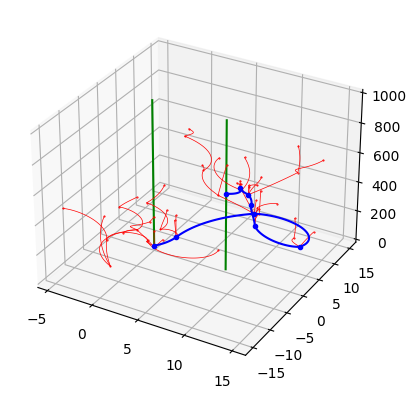

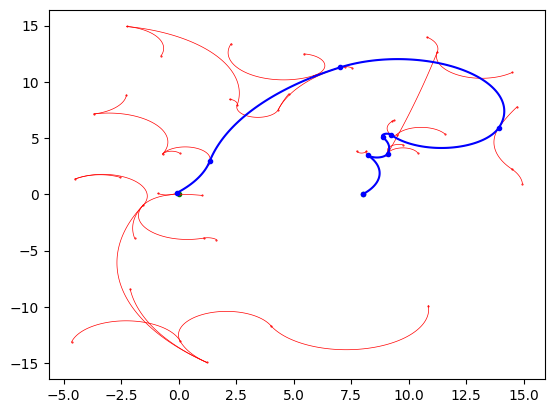

In [15]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D([x0[0], x0[0]], [x0[1], x0[1]], [x0[2], 1000], '-g')
ax.plot3D([x1[0], x1[0]], [x1[1], x1[1]], [0, 1000], '-g')
for i in G_WG['vertex_with_time'].keys():
    vi = G_WG['vertex_with_time'][str(i)]
    ax.plot3D(vi[0][0], vi[0][1], vi[1], '.r', markersize=1)
for i in G_WG['edge'].keys():
    e = G_WG['edge'][str(i)]
    ax.plot3D(e['x'], e['y'], e['t'], '-r', linewidth=0.5)
for i in G_WG['route']:
    vi = G_WG['vertex_with_time'][i]
    ax.plot3D(vi[0][0], vi[0][1], vi[1], '.b')
    ei = G_WG['edge'][i]
    ax.plot3D(ei['x'], ei['y'], ei['t'], '-b')

fig = plt.figure()
plt.plot(x0[0], x0[1], '.g')
plt.plot(x1[0], x1[1], '.g')
for i in G_WG['vertex_with_time'].keys():
    vi = G_WG['vertex_with_time'][str(i)]
    plt.plot(vi[0][0], vi[0][1], '.r', markersize=1)
for i in G_WG['edge'].keys():
    e = G_WG['edge'][str(i)]
    plt.plot(e['x'], e['y'], '-r', linewidth=0.5)
for i in G_WG['route']:
    vi = G_WG['vertex_with_time'][i]
    plt.plot(vi[0][0], vi[0][1], '.b')
    ei = G_WG['edge'][i]
    plt.plot(ei['x'], ei['y'], '-b')



In [16]:
print(success_waitGo)
print(success_RRTC)
adfadfafafafd

1
0


NameError: name 'adfadfafafafd' is not defined

Text(0, 0.5, 'Success Rate')

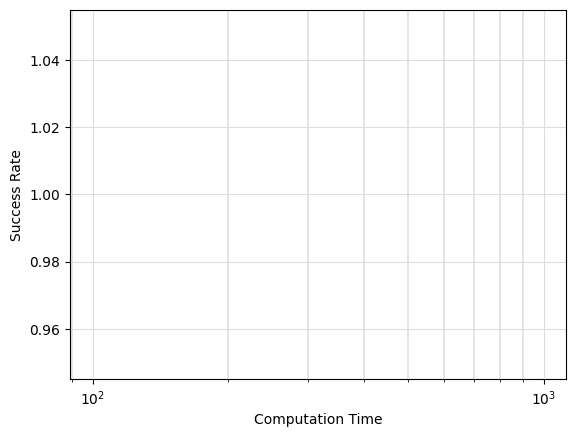

In [ ]:
fig = plt.figure()
ax = plt.subplot(1,1,1)
plt.plot(compTimeVec, success_vec_waitGo, '-r')
plt.plot(compTimeVec, success_vec_RRTC, '--b', alpha=0.5)
ax.set_xscale('log')
# plt.legend(['RRT-Connect with Wait-Go', 'RRT-Connect'])
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(which='minor', color='k', linewidth=0.15)
plt.xlabel('Computation Time')
plt.ylabel('Success Rate')

In [ ]:
afdasfdafasfsa

NameError: name 'afdasfdafasfsa' is not defined

Computation Time:  0.1
total time spent:  5.2439141273498535
Computation Time:  1
total time spent:  41.027429819107056
Computation Time:  5
total time spent:  180.54600358009338
Computation Time:  10
total time spent:  306.1093153953552
Computation Time:  20
total time spent:  381.8490660190582
Computation Time:  30
total time spent:  536.2684502601624


Text(0, 0.5, 'Success Rate')

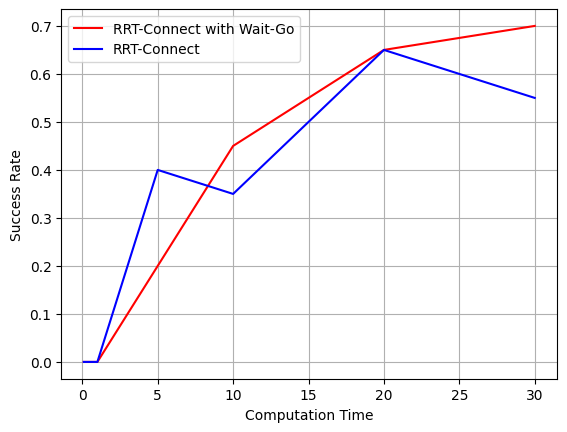

In [ ]:
wait_switch = [0.85, 0.1, 0.05]
RRTC_switch = [0.95, 0,   0.05]
success_vec_waitGo = []
success_vec_RRTC = []
avg_compTime_vec_waitGo = []
avg_compTime_vec_RRTC = []

for ti in compTimeVec:
    # Single camera example, surveying final location xfin
    # Camera Position
    cam_x = np.array([7.5])
    # cam_y = np.array([rn.uniform(-10, 10)])
    cam_y = np.array([rn.uniform(-5, 5)])
    cam_dict = {}
    cam_dict['n'] = len(cam_x)
    cam_dict['x'] = cam_x
    cam_dict['y'] = cam_y

    # Camera Spec
    tilt_limit = np.array([np.pi, 0]) #[upper, lower]
    fov_ang = 20#np.deg2rad(rn.uniform(10, 30))
    fov_rng = 7.5 #[m]
    cam_period = t[0]
    cam_increment = t[1]
    cam_dict['spec'] = {}
    cam_dict['spec']['bound'] = tilt_limit
    cam_dict['spec']['fov'] = [fov_ang, fov_rng]
    cam_dict['spec']['cam_time'] = [cam_period, cam_increment]

    start = time.time()
    print('Computation Time: ', ti)
    success_waitGo = 0
    success_RRTC = 0
    counter = 0
    for mc_ii in range(mc_iter):
        # print('iter: ', counter)
        # path_obtained, RRTWait = test.R2T2_2D(ti, wait_switch)
        path_obtained_waitGo, compTime_waitGo, WG_exec_time_dict = test.R2T2_2D(ti, wait_switch)
        success_waitGo += path_obtained_waitGo

        path_obtained_RRTC, compTime_RRTC, RRTC_exec_time_dict = test.R2T2_2D(ti, RRTC_switch)
        success_RRTC += path_obtained_RRTC
        counter += 1
    success_vec_waitGo.append(success_waitGo/mc_iter)
    success_vec_RRTC.append(success_RRTC/mc_iter)
    print('total time spent: ', time.time()-start)
    avg_compTime_vec_waitGo.append(compTime_waitGo)
    avg_compTime_vec_RRTC.append(compTime_RRTC)

fig = plt.figure()
plt.plot(compTimeVec, success_vec_waitGo, '-r')
plt.plot(compTimeVec, success_vec_RRTC, '-b')
plt.legend(['RRT-Connect with Wait-Go', 'RRT-Connect'])
plt.grid()
plt.xlabel('Computation Time')
plt.ylabel('Success Rate')

In [ ]:
print(G_WG['vertex_with_time'].keys())

dict_keys(['0', '1', '4', '6', '12', '15', '17', '19', '22', '24', '26', '28', '30', '32', '35', '37', '40', '43', '46', '48', '50', '57', '59', '67', '69', '72', '74', '78'])


518.3360783271589


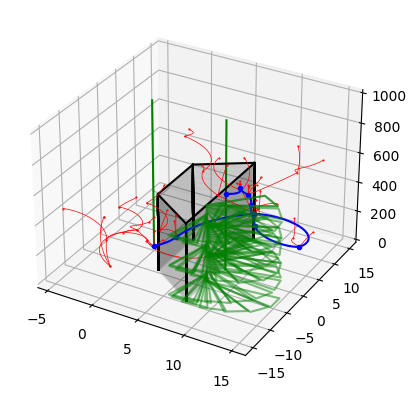

In [17]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D([x0[0], x0[0]], [x0[1], x0[1]], [x0[2], 1000], '-g')
ax.plot3D([x1[0], x1[0]], [x1[1], x1[1]], [0, 1000], '-g')

vertex_keys = list(G_WG['vertex_with_time'].keys())
print(G_WG['vertex_with_time'][str(vertex_keys[-1])][1])
total_points = len(G_WG['vertex_with_time'])

for ii in range(len(vertex_keys[0:10])):
    keyi = vertex_keys[ii]
    vi = G_WG['vertex_with_time'][keyi]
    ax.plot3D(vi[0][0], vi[0][1], vi[1], '.r', markersize=1)

R2T2_tvec = np.linspace(0, G_WG['vertex_with_time'][str(vertex_keys[-1])][1], total_points)
for i in range(map_in['st']['n']):
    ibuilding = map_in['st'][str(i)]
    wall = geometry.LineString(ibuilding)
    building = geometry.Polygon(wall)
    bx,by = building.exterior.xy
    for st_i in R2T2_tvec:
        # Currently set alpha = 0
        plt.plot(bx, by, st_i, '-k', alpha=.1)
        for i in range(5):
            plt.plot([bx[i], bx[i]], [by[i], by[i]], [0, st_i], '-k')
plt.plot(bx, by, st_i, '-k', alpha=1)
dmap = map_in['dy']
R2T2_tvec = np.linspace(0, G_WG['vertex_with_time'][str(vertex_keys[-1])][1], total_points)
for st_i in R2T2_tvec:
    cameras = dmap.gen_cam(st_i)
    ncam = cameras['n']
    for ii in range(ncam):
        cam_i = cameras[str(ii)]['FOV_Poly']
        cx, cy = cam_i.exterior.xy
        plt.plot(cx, cy, st_i, '-g', alpha=0.5, zorder=5)
plt.plot(cx, cy, st_i, '-g', alpha=0.5, zorder=5)


for i in G_WG['vertex_with_time'].keys():
    vi = G_WG['vertex_with_time'][str(i)]
    ax.plot3D(vi[0][0], vi[0][1], vi[1], '.r', markersize=1)
for i in G_WG['edge'].keys():
    e = G_WG['edge'][str(i)]
    ax.plot3D(e['x'], e['y'], e['t'], '-r', linewidth=0.5)
for i in G_WG['route']:
    vi = G_WG['vertex_with_time'][i]
    ax.plot3D(vi[0][0], vi[0][1], vi[1], '.b')
    ei = G_WG['edge'][i]
    ax.plot3D(ei['x'], ei['y'], ei['t'], '-b')


In [18]:
# Procedure
# 1. Extract time index for each vertex / edge
# 2. Sort out vertex, edge by time
# 3. At each timestamp marked, note position of sensor

# 1-1. Extract Time Index on Vertex
vertex_keys = list(G_WG['vertex_with_time'].keys())
vertex_time_vec = []
for key in vertex_keys:
    vertex_time_vec.append(G_WG['vertex_with_time'][key][1])
vertex_time_vec = sorted(vertex_time_vec)

# Match sorted time vetex with Keys
sorted_key_list = []
for curr_time_stamp in vertex_time_vec:
    for key in vertex_keys:
        if G_WG['vertex_with_time'][key][1] == curr_time_stamp:
            sorted_key_list.append(key)
            break

print(vertex_time_vec)
print(sorted_key_list)
print(G_WG['vertex_with_time'].keys())
print(G_WG['edge'].keys())



[0, 7.634701642220398, 24.56712169414883, 34.40387955935651, 34.90326082617534, 36.959222123378055, 75.40019213420055, 97.91467714562319, 116.06885082613334, 116.7691217322848, 129.60919242524758, 141.40964022913278, 150.27461923964557, 156.5908379202185, 172.3157557195853, 173.32784898895036, 185.89208967449363, 188.35393217727275, 211.57296029333682, 214.88486234442502, 218.15714093151462, 220.87991070808982, 227.531891317032, 270.88029030304034, 272.3226501760459, 281.1462008722889, 286.9788623737913, 289.2321450800299, 289.4576960041052, 330.3129399497792, 333.35800312720494, 339.91611824724635, 353.4109995965779, 354.8477501709763, 377.4041828383596, 395.2710305163562, 403.10769755739943, 405.65984462220905, 420.01317718612466, 429.4702423431198, 439.2800697839602, 440.9413467176353, 457.6406654679338, 459.3720933262347, 460.73778288898393, 463.0382653539554, 463.83632970030584, 470.4635748325277, 477.3192168425792, 491.59222681354777, 506.6634051361559, 508.02644579735136, 508.67

In [19]:
from matplotlib.animation import FuncAnimation

114
0/114
0/114
1/114
2/114
3/114
4/114
5/114
6/114
7/114
8/114
9/114
10/114
11/114
12/114
13/114
14/114
15/114
16/114
17/114
18/114
19/114
20/114
21/114
22/114
23/114
24/114
25/114
26/114
27/114
28/114
29/114
30/114
31/114
32/114
33/114
34/114
35/114
36/114
37/114
38/114
39/114
40/114
41/114
42/114
43/114
44/114
45/114
46/114
47/114
48/114
49/114
50/114
51/114
52/114
53/114
54/114
55/114
56/114
57/114
58/114
59/114
60/114
61/114
62/114
63/114
64/114
65/114
66/114
67/114
68/114
69/114
70/114
71/114
72/114
73/114
74/114
75/114
76/114
77/114
78/114
79/114
80/114
81/114
82/114
83/114
84/114
85/114
86/114
87/114
88/114
89/114
90/114
91/114
92/114
93/114
94/114
95/114
96/114
97/114
98/114
99/114
100/114
101/114
102/114
103/114
104/114
105/114
106/114
107/114
108/114
109/114
110/114
111/114
112/114
113/114
Plotting Path
0/114


<Figure size 640x480 with 0 Axes>

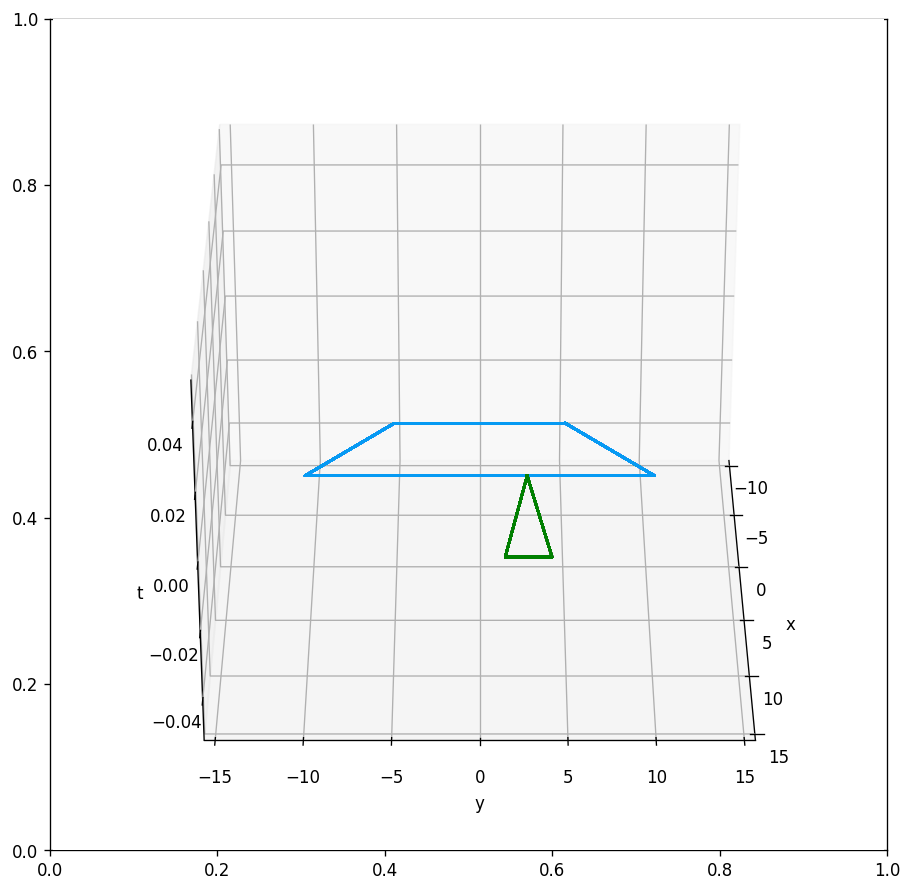

In [ ]:
# Normal 
plt.clf()
figure, ax = plt.subplots(figsize=(9, 9), dpi=(1920/16))
ax = plt.axes(projection='3d')

# Total points
total_points = 0
total_points += len(G_WG['vertex_with_time'])
print(total_points)
view_rotation_angle_vector = np.linspace(0, 180, total_points)
 
# Since plotting a single graph
def animation_function(i):
    # plt.clf()
    plt. cla()
    # Obstacle
    vertex_keys = list(G_WG['vertex_with_time'].keys())
    t_fin = G_WG['vertex_with_time'][str(vertex_keys[-1])][1]
    t_curr = G_WG['vertex_with_time'][str(vertex_keys[i])][1]
    R2T2_tvec = np.linspace(0, t_curr, total_points)

    ax.plot3D([x0[0], x0[0]], [x0[1], x0[1]], [x0[2], t_curr], '--', zorder=5, linewidth=1, color='#FC5A50')
    ax.plot3D([x1[0], x1[0]], [x1[1], x1[1]], [0, t_curr], '--', zorder=5, linewidth=1, color='#303764')

    print(str(i)+'/'+str(total_points))
    i = int(i)
    # RRTConnect
    vertex_keys = list(G_WG['vertex_with_time'].keys())
    for ii in range(len(vertex_keys[0:i])):
        keyi = vertex_keys[ii]
        vi = G_WG['vertex_with_time'][keyi]
        ax.plot3D(vi[0][0], vi[0][1], vi[1], '.r', linewidth=1, zorder=3)#, alpha=.5/total_points)
    if i > 0:
        edge_keys = list(G_WG['edge'].keys())
        for ii in range(len(edge_keys[0:i])):
            keyi = edge_keys[ii]
            e = G_WG['edge'][keyi]
            ax.plot3D(e['x'], e['y'], e['t'], '-r', linewidth=1.5, zorder=3)#, alpha=.5/total_points)

    if i == total_points-1:
        print('Plotting Path')
        for route_keyi in G_WG['route']:
            ax.plot3D(G_WG['vertex_with_time'][route_keyi][0][0], G_WG['vertex_with_time'][route_keyi][0][1], G_WG['vertex_with_time'][route_keyi][1], '.b', linewidth=2.5, zorder=10)
            ax.plot3D(G_WG['edge'][route_keyi]['x'], G_WG['edge'][route_keyi]['y'], G_WG['edge'][route_keyi]['t'], '-b', linewidth=2.5, zorder=10)
    
    # Plot Building
    # building_alpha = (0.5/(i+1))
    building_alpha = 0.5
    for ii in range(map_in['st']['n']):
        ibuilding = map_in['st'][str(ii)]
        wall = geometry.LineString(ibuilding)
        building = geometry.Polygon(wall)
        bx,by = building.exterior.xy
        
        for st_i in R2T2_tvec:
            ax.plot3D(bx, by, st_i, '-', color='#069AF3', alpha=building_alpha, zorder=3)
            for iii in range(5):
                ax.plot3D([bx[iii], bx[iii]], [by[iii], by[iii]], [0, st_i], '-', color='#069AF3', linewidth=1, zorder=4)
            if st_i == R2T2_tvec[-1]:
                ax.plot3D(bx, by, st_i, '-', color='#069AF3', linewidth=1, zorder=3)

    # Plot Cameras
    dmap = map_in['dy']
    for st_i in R2T2_tvec:
        cameras = dmap.gen_cam(st_i)
        ncam = cameras['n']
        for ii in range(ncam):
            cam_i = cameras[str(ii)]['FOV_Poly']
            cx, cy = cam_i.exterior.xy
            plt.plot(cx, cy, st_i, '-g', alpha=0.25, zorder=5)
    # plt.plot(cx, cy, st_i, '-g', alpha=0.25, zorder=5)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('t')
    ax.set_xlim(-10, 15)
    ax.set_ylim(-15, 15)
    ax.view_init(elev=30, azim=view_rotation_angle_vector[i])
    # ax.view_init(elev=90)
    # ax.set_zlim(0, 10)

animation = FuncAnimation(figure,
                          func = animation_function,
                          frames = np.arange(0, total_points, 1), 
                        #   frames = np.arange(0, 10, 1), 
                        #   frames = np.arange(total_points-1, total_points, 1), 
                          interval = 50)
animation.save('2D_RRT_WG_test3.mp4', writer="ffmpeg")
# fig.show()

In [ ]:
print(sorted_key_list[1:])
print(sorted_key_list[1:-1])

['27', '18', '5', '34', '7', '256', '67', '58', '11', '104', '9', '16', '44', '111', '32', '89', '47', '87', '50', '22', '14', '36', '29', '145', '62', '20', '60', '65', '77', '52', '156', '69', '219', '98', '241', '133', '141', '94', '56', '158', '38', '72', '96', '75', '40', '24', '230', '278', '42', '147', '54', '178', '164', '85', '117', '100', '128', '258', '293', '81', '171', '243', '106', '204', '130', '92', '120', '186', '254', '160', '162', '102', '115', '108', '281', '136', '143', '125', '264', '206', '169', '176', '113', '191', '152', '237', '174', '270', '150', '199', '154', '272', '208', '223', '247', '266', '274', '286', '284', '183', '193', '211', '295', '189', '228', '216', '214', '235', '221', '251', '196', '260', '290']
['27', '18', '5', '34', '7', '256', '67', '58', '11', '104', '9', '16', '44', '111', '32', '89', '47', '87', '50', '22', '14', '36', '29', '145', '62', '20', '60', '65', '77', '52', '156', '69', '219', '98', '241', '133', '141', '94', '56', '158', '38'

[0, 7.634701642220398, 24.56712169414883, 34.40387955935651, 34.90326082617534, 36.959222123378055, 75.40019213420055, 97.91467714562319, 116.06885082613334, 116.7691217322848, 129.60919242524758, 141.40964022913278, 150.27461923964557, 156.5908379202185, 172.3157557195853, 173.32784898895036, 185.89208967449363, 188.35393217727275, 211.57296029333682, 214.88486234442502, 218.15714093151462, 220.87991070808982, 227.531891317032, 270.88029030304034, 272.3226501760459, 281.1462008722889, 286.9788623737913, 289.2321450800299, 289.4576960041052, 330.3129399497792, 333.35800312720494, 339.91611824724635, 353.4109995965779, 354.8477501709763, 377.4041828383596, 395.2710305163562, 403.10769755739943, 405.65984462220905, 420.01317718612466, 429.4702423431198, 439.2800697839602, 440.9413467176353, 457.6406654679338, 459.3720933262347, 460.73778288898393, 463.0382653539554, 463.83632970030584, 470.4635748325277, 477.3192168425792, 491.59222681354777, 506.6634051361559, 508.02644579735136, 508.67

<Figure size 640x480 with 0 Axes>

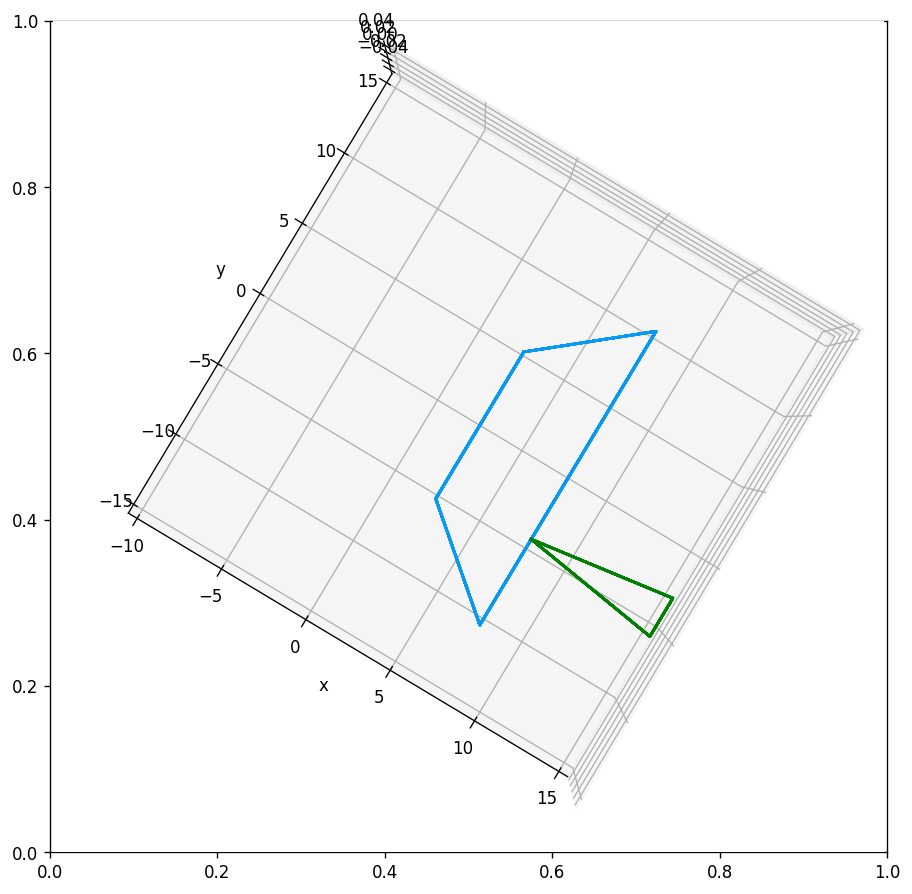

In [22]:
# Timelaps 
plt.clf()
figure, ax = plt.subplots(figsize=(9, 9), dpi=(1920/16))
ax = plt.axes(projection='3d')

print(vertex_time_vec)
print(sorted_key_list)

# Total points
total_points = 0
total_points += len(G_WG['vertex_with_time'])
print(total_points)
view_rotation_angle_vector = np.linspace(-80, 80, total_points)

# Setting limits for x and y axis
 
# Since plotting a single graph
def animation_function(i):
    # plt.clf()
    plt. cla()
    # Obstacle
    vertex_keys = sorted_key_list
    t_fin = G_WG['vertex_with_time'][str(vertex_keys[-1])][1]
    t_curr = G_WG['vertex_with_time'][str(vertex_keys[i])][1]
    R2T2_tvec = np.linspace(0, t_curr, total_points)

    ax.plot3D([x0[0], x0[0]], [x0[1], x0[1]], [x0[2], t_curr], '--', zorder=5, linewidth=1, color='#FC5A50')
    ax.plot3D([x1[0], x1[0]], [x1[1], x1[1]], [0, t_curr], '--', zorder=5, linewidth=1, color='#303764')

    print(str(i)+'/'+str(total_points))
    i = int(i)
    # RRTConnect
    for ii in range(len(vertex_keys[0:i])):
        keyi = vertex_keys[ii]
        vi = G_WG['vertex_with_time'][keyi]
        ax.plot3D(vi[0][0], vi[0][1], vi[1], '.r', linewidth=1, zorder=3)#, alpha=.5/total_points)
    if i > 1:
        edge_keys = sorted_key_list[1:]
        for ii in range(len(edge_keys[0:i-1])):
            keyi = edge_keys[ii]
            e = G_WG['edge'][keyi]
            ax.plot3D(e['x'], e['y'], e['t'], '-r', linewidth=1.5, zorder=3)#, alpha=.5/total_points)

    if i == total_points-1:
        print('Plotting Path')
        for route_keyi in G_WG['route']:
            ax.plot3D(G_WG['vertex_with_time'][route_keyi][0][0], G_WG['vertex_with_time'][route_keyi][0][1], G_WG['vertex_with_time'][route_keyi][1], '.b', linewidth=2.5, zorder=10)
            ax.plot3D(G_WG['edge'][route_keyi]['x'], G_WG['edge'][route_keyi]['y'], G_WG['edge'][route_keyi]['t'], '-b', linewidth=2.5, zorder=10)
    
    # Plot Building
    # building_alpha = (0.5/(i+1))
    building_alpha = 0.5
    for ii in range(map_in['st']['n']):
        ibuilding = map_in['st'][str(ii)]
        wall = geometry.LineString(ibuilding)
        building = geometry.Polygon(wall)
        bx,by = building.exterior.xy
        
        for st_i in R2T2_tvec:
            ax.plot3D(bx, by, st_i, '-', color='#069AF3', alpha=building_alpha, zorder=4)
            for iii in range(5):
                ax.plot3D([bx[iii], bx[iii]], [by[iii], by[iii]], [0, st_i], '-', color='#069AF3', linewidth=1, zorder=4)
            if st_i == R2T2_tvec[-1]:
                ax.plot3D(bx, by, st_i, '-', color='#069AF3', linewidth=1, zorder=4)

    # Plot Cameras
    dmap = map_in['dy']
    for st_i in R2T2_tvec:
        cameras = dmap.gen_cam(st_i)
        ncam = cameras['n']
        for ii in range(ncam):
            cam_i = cameras[str(ii)]['FOV_Poly']
            cx, cy = cam_i.exterior.xy
            plt.plot(cx, cy, st_i, '-g', alpha=0.25, zorder=5)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('t')
    ax.set_xlim(-10, 15)
    ax.set_ylim(-15, 15)
    # ax.view_init(elev=25, azim=view_rotation_angle_vector[i])
    ax.view_init(elev=90)
    # ax.set_zlim(0, 10)

animation = FuncAnimation(figure,
                          func = animation_function,
                          frames = np.arange(0, total_points, 1), 
                        #   frames = np.arange(0, 20, 1), 
                        #   frames = np.arange(total_points-1, total_points, 1), 
                          interval = 100)
animation.save('2D_RRT_WG_timelaps05-1.mp4', writer="ffmpeg")
# fig.show()